## Build XGBoost model for ligament data
Zeyu Tang \
Clemson University \
07/2025 \
tmc_xgboost.ipynb \
Purpose: train and evaluate XGBoost model using tabular data of ligament measures. 

### Dependencies

In [40]:
import glob
import numpy as np
import os
import collections
import sys

import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt

import csv

import argparse
import yaml
import xgboost as xgb 

from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
with open('configs.yaml', 'r') as file:
    configs = yaml.safe_load(file)

#### XGBoost on static data

In [52]:
# Perform cross-validation
cv_configs = configs['cv_configs']
kf = KFold(n_splits=cv_configs['num_splits'], shuffle=True, random_state=cv_configs['random_seed'])

gt_path = configs['gt_path']
# Load ground truth labels and data
with open(configs['gt_path'], 'rb') as file:
    grades = pickle.load(file)
with open(os.path.join(configs['processed_data_path'], 'static_data.pkl'), 'rb') as file:
    static_data = pickle.load(file)
    
static_hid = list(static_data.keys())
sample_codes = list(grades['group'].keys())

In [53]:
results_path = os.path.join(configs['results_path'], 'static_model')
os.makedirs(results_path, exist_ok=True)

Old grading scheme
#class: 5
Counter({2: 11, 1: 8, 0: 6, 3: 6, 4: 1})
Accuracy: 0.3125
Precision: 0.3125
Recall: 0.3125


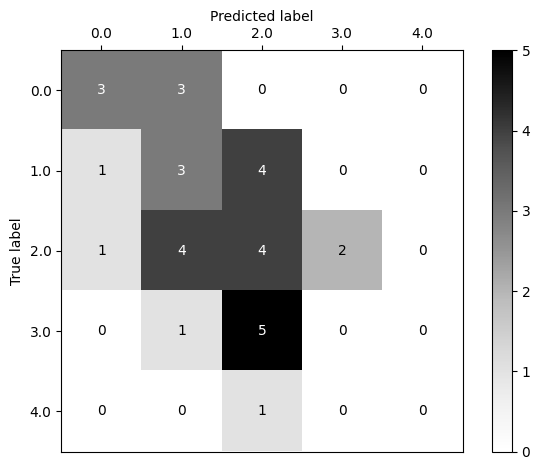

In [73]:
''' Old grading scheme
'''
print("Old grading scheme")

all_preds = np.array([])
all_labels = np.array([])
y_static = [grades['old'][hid] for hid in static_hid]
num_classes = len(np.unique(y_static))
print(f"#class: {num_classes}")
print(collections.Counter(y_static))

model = xgb.XGBClassifier(n_estimators=100,
                learning_rate=0.01,
                max_depth=10,
                subsample=0.8,
                colsample_bytree=0.9,
                objective='multi:softprob',
                num_class=len(np.unique(y_static)))

# Save detailed results for future analysis
file = open(os.path.join(results_path, 'result_old.csv'), mode='w', newline='')
writer = csv.writer(file)
# Write the header
writer.writerow(['Fold', 'Sample Code', 'Prediction', 'Ground Truth']+[f'P{class_}' for class_ in range(num_classes)])
# Loop through each fold
for fold, (train_index, test_index) in enumerate(kf.split(sample_codes)):
    x_train = []
    y_train = []
    for hid in np.array(sample_codes)[train_index]:
        if hid in static_hid:
            x_train.append(np.concatenate(static_data[hid], axis=0))
            y_train.append(grades['old'][hid])
    x_train = np.array(x_train)
    y_train = np.array(y_train)     

    x_test = []
    y_test = []
    hid_test = []
    for hid in np.array(sample_codes)[test_index]:
        if hid in static_hid:
            x_test.append(np.concatenate(static_data[hid], axis=0))
            y_test.append(grades['old'][hid])
            hid_test.append(hid)
    x_test = np.array(x_test)
    y_test = np.array(y_test)                
    
    # Z-score
    mean = np.mean(x_train, axis=0)
    std = np.std(x_train, axis=0)
    x_train = (x_train-mean)/std
    x_test = (x_test-mean)/std
    
    # Set class weights
    classes = np.unique(y_train)  
    class_sizes = np.array(sorted(collections.Counter(y_train).values()))
    # computes the weight using inversed square root of class frequencies
    class_weights = 1/class_sizes**(0.5)
    sample_weights = np.array([class_weights[label] for label in y_train])

    model.fit(x_train, y_train, sample_weight=sample_weights)

    y_probs = model.predict_proba(x_test)
    y_pred = np.argmax(y_probs,axis=1)
    all_preds = np.concatenate((all_preds, y_pred))
    all_labels = np.concatenate((all_labels, y_test))

    for hid, pred, gt, probs in zip(hid_test, y_pred, y_test, y_probs):
        writer.writerow([fold+1, hid, pred, gt]+list(probs))
file.close()

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='micro')
recall = recall_score(all_labels, all_preds, average='micro')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Greys, ax=ax)
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top
ax.xaxis.tick_top()  # Move the x-axis ticks to the top
# plt.title('Confusion Matrix')
plt.tight_layout() 
plt.show()

New grading scheme
#class: 2
Counter({1: 23, 0: 9})
Accuracy: 0.6875
Precision: 0.6875
Recall: 0.6875


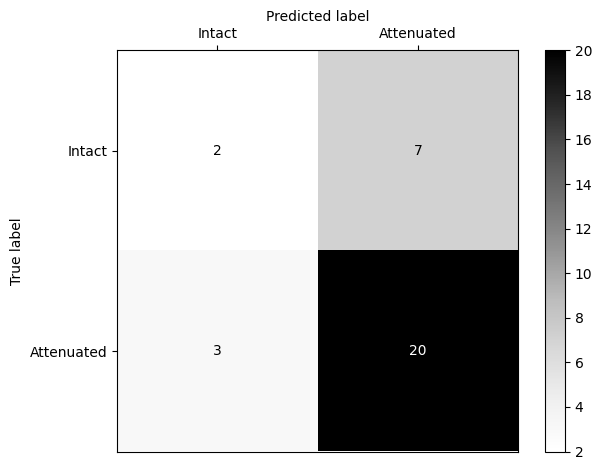

In [74]:
''' New grading scheme
'''
print("New grading scheme")
static_hid = list(static_data.keys())
all_preds = np.array([])
all_labels = np.array([])
y_static = {hid: grades['ligament'][hid] for hid in static_hid}
num_classes = len(set(y_static.values()))
print(f"#class: {num_classes}")
print(collections.Counter(y_static.values()))

# Save detailed results for future analysis
file = open(os.path.join(results_path, 'result_ligament.csv'), mode='w', newline='')
writer = csv.writer(file)
# Write the header
writer.writerow(['Fold', 'Sample Code', 'Prediction', 'Ground Truth']+[f'P{class_}' for class_ in range(num_classes)])

# Loop through each fold
for fold, (train_index, test_index) in enumerate(kf.split(sample_codes)):
    x_train = []
    y_train = []
    for hid in np.array(sample_codes)[train_index]:
        if hid in static_hid:
            x_train.append(np.concatenate(static_data[hid], axis=0))
            y_train.append(y_static[hid])
    x_train = np.array(x_train)
    y_train = np.array(y_train)     

    x_test = []
    y_test = []
    hid_test = []
    for hid in np.array(sample_codes)[test_index]:
        if hid in static_hid:
            x_test.append(np.concatenate(static_data[hid], axis=0))
            y_test.append(y_static[hid])
            hid_test.append(hid)
    x_test = np.array(x_test)
    y_test = np.array(y_test)                
    
#     # Z-score
    mean = np.mean(x_train, axis=0)
    std = np.std(x_train, axis=0)
    x_train = (x_train-mean)/std
    x_test = (x_test-mean)/std
    
    # Set class weights
    classes = np.unique(y_train)  
    # computes the weight using inversed square root of class frequencies
    class_sizes = np.array(sorted(collections.Counter(y_train).values()))
    # class_weights = 1/class_sizes**(0.5)
    sample_weights = np.array([class_weights[label] for label in y_train])
    
    model = xgb.XGBClassifier(n_estimators=5,
                learning_rate=0.01,
                max_depth=20,
                subsample=0.8,
                colsample_bytree=0.9,
                objective='binary:logistic')
    model.fit(x_train, y_train, 
              # sample_weight=sample_weights
             )
    y_probs = model.predict_proba(x_test)
    y_pred = np.argmax(y_probs,axis=1)
    all_preds = np.concatenate((all_preds, y_pred))
    all_labels = np.concatenate((all_labels, y_test))

    for hid, pred, gt, probs in zip(hid_test, y_pred, y_test, y_probs):
        writer.writerow([fold+1, hid, pred, gt]+list(probs))

file.close()     

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='micro')
recall = recall_score(all_labels, all_preds, average='micro')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Intact','Attenuated'])
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Greys, ax=ax)
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top
ax.xaxis.tick_top()  # Move the x-axis ticks to the top
# plt.title('Confusion Matrix')
plt.tight_layout() 
plt.show()